In [26]:
import os 
import random
import warnings

import numpy as np
import pandas as pd
from tqdm import tqdm
from package.utils import (absolute,
                           merge_dataframe,
                           infile_concat,
                           normalization)
from package.vad_filter import feature_generation
from package.vad_filter import feature_generation_sh
from package.smoothing import total_turn_taking, turn_taking, smoothing
from package.clf import (logistic_regression,
                         neural_network,
                         gradient_boosting,
                         voting_classifier,
                         stacking_classifier,
                         lightGBM,
                         AUC, 
                         Accuracy, 
                         Sensitivity,
                         Specificity,
                         result)
from package.vis import *

In [2]:
path = "../origin_data/"

In [3]:
random.seed(921)

In [4]:
datalist = os.listdir(path)
datalist = [file for file in datalist if '.xlsx' in file] # path 경로에서 .xlsx 가 있는 파일만 불러와서 datalist에 담기

filename = []
for file in tqdm(datalist) :
    file = file.replace(".xlsx", "") # datalist 에 불러온 파일명에서 .xlsx 지우기 
    
    # 데이터 프레임 이름을 파일 이름으로 지정 
    globals()['df_{}'.format(file)] = pd.read_excel(path + "{}.xlsx".format(file), encoding = 'cp949')
    
    # 파일에 있는 컬럼 중에서 사용할 컬럼만 지정 
    globals()['df_{}'.format(file)] = globals()['df_{}'.format(file)][['#1_snd', '#2_snd', '#3_snd', '#1_talking', '#2_talking', '#3_talking']]
    
    # 지정한 컬럼 이름을 변경 
    globals()['df_{}'.format(file)].columns = ['x1','x2','x3','y1','y2','y3'] 
    filename.append('df_' + file)

100%|██████████| 60/60 [00:37<00:00,  1.60it/s]


In [5]:
# 위의 전처리 (정규화, 절댓값, x1x2x3 / y1y2y3 세로로 이어주기) 를 마친 파일을 p_filename 에 담아준다.
p_filename = []
for f in filename : 
    df = globals()[f]
    norm_df = normalization(df)
    abs_df = absolute(norm_df)
    concat_df = infile_concat(abs_df)
    globals()['p_{}'.format(f)] = concat_df # p_df = preprocessed data
    p_filename.append('p_' + f)

In [6]:
# 모든 시나리오 파일에 대해 파생변수 생성하여 complete_filename에 담는다. 
complete_filename = []
for f in tqdm(p_filename) : 
    df = globals()[f]
    comp_df = feature_generation(df)
    globals()['comp_{}'.format(f)] = comp_df # comp_ =complete
    complete_filename.append('comp_' + f)

100%|██████████| 60/60 [00:04<00:00, 12.19it/s]


In [7]:
# 신호측정이 이상한 파일 제거 :
# 총 60개의 파일 중에서 10개의 파일이 이상함
# 50개의 시나리오 파일만 활용할 예정
## 10개의 파일을 제거한 50개의 파일을 clearfile에 담는다. 

bad_file = ['comp_p_df_12th_short_01', 'comp_p_df_14th_turn_02', 'comp_p_df_15th_turn_01', 
            'comp_p_df_15th_turn_02', 'comp_p_df_3rd_short_01', 'comp_p_df_6th_turn_02', 
            'comp_p_df_7th_short_01', 'comp_p_df_7th_turn_01', 'comp_p_df_9th_turn_01', 
            'comp_p_df_9th_turn_02']

clearfile = complete_filename.copy()
clearfile = [x for x in clearfile if x not in bad_file]

In [8]:
short = [file for file in clearfile if 'short' in file]
t1 = [file for file in clearfile if 'turn_01' in file]
t2 = [file for file in clearfile if 'turn_02' in file]
t3 = [file for file in clearfile if 'turn_03' in file]

In [9]:
print("shrot : {} \n turn_01 : {} \n turn_02 : {} \n turn_03 : {}".format(len(short), len(t1), len(t2), len(t3)))

shrot : 12 
 turn_01 : 12 
 turn_02 : 11 
 turn_03 : 15


In [10]:
# 램덤하게 시나리오 순서를 돌려준다. 
random.shuffle(short) 
random.shuffle(t1)
random.shuffle(t2)
random.shuffle(t3)

data = []
sett = [[9,8,8,10],[3,4,3,5]]
# sett = [[test], [train1], [train2], [train3]] 의 구성을 의미. 각각의 대괄호 안의 숫자는 순서대로 short, turn01, turn02, turn03 의 시나리오의 개수를 의미함. 
## ex. [1, 2, 1, 1] --> short 시나리오: 1개, turn1 시나리오: 2개, turn2 시나리오: 1개, turn3 시나리오: 1개 

# 아래 s1, s2, s3, s4는 각각 [1,5,3,3], [2,2,4,4], [1,3,3,4], [1,5,5,4]를 의미 
## ex. s1 는 test, train1, train2, train3 각각의 첫 번 째 숫자를 의미 (short 시나리오 개수)
for s1,s2,s3,s4 in sett:
    fold = []
    for i in range(s1): # s1 = [1,5,3,3] 이므로 loop를 돌면서 short 시나리오를 1개, 5개, 3개, 3개를 뽑아서 fold에 저장  
        fold.append(short.pop()) # pop 을 씀으로써, 뽑은 시나리오는 삭제한다. 
    for i in range(s2):
        fold.append(t1.pop())
    for i in range(s3):
        fold.append(t2.pop())
    for i in range(s4):
        fold.append(t3.pop())
    data.append(fold)

In [11]:
train = merge_dataframe(globals(), data[0]) # 위의 [9,8,8,10] 데이터를 하나로 이어줌.
test = merge_dataframe(globals(), data[1])    # 위의 [3,4,3,5] test

In [12]:
## Train X, Y
### 위의 train_1, train_2, train_3, test 의 시그널 (x = 26개의 변수) 부분과, 발화 여부 (y = 0 or 1) 부분으로 나눠준다.  
train_x = train.iloc[:, 1:-1]
train_y = train.iloc[:, -1]
## Test X, Y 
test_x = test.iloc[:, 1:-1]
test_y = test.iloc[:, -1]

print(train_x.shape)
print(test_x.shape)

train_tuple = (train_x, train_y)

(952110, 26)
(434646, 26)


In [13]:
temp = pd.DataFrame(test_y).reset_index(drop=True)
temp.columns = ['new_smth']
true_test = temp.copy()

In [14]:
train_x

,signal,ga10,ga50,ga100,ga200,ga300,sa10,sa50,sa100,sa200,...,ma10,ma50,ma100,ma200,ma300,sd10,sd50,sd100,sd200,sd300
0,0.071940,0.042469,0.034748,0.032621,0.060149,0.241283,0.043284,0.032152,0.026395,-0.320405,...,0.071940,0.071940,0.071940,0.071940,0.071940,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.006441,0.040881,0.034705,0.032617,0.060275,0.241472,0.041785,0.032167,0.026555,-0.307212,...,0.039191,0.039191,0.039191,0.039191,0.039191,0.046315,0.046315,0.046315,0.046315,0.046315
2,0.022816,0.039223,0.034621,0.032609,0.060524,0.241850,0.040285,0.032182,0.026715,-0.294019,...,0.033733,0.033733,0.033733,0.033733,0.033733,0.034087,0.034087,0.034087,0.034087,0.034087
3,0.088315,0.037860,0.034497,0.032596,0.060900,0.242419,0.038786,0.032198,0.026875,-0.280826,...,0.047378,0.047378,0.047378,0.047378,0.047378,0.038980,0.038980,0.038980,0.038980,0.038980
4,0.006441,0.036245,0.034337,0.032579,0.061405,0.243174,0.037286,0.032213,0.027035,-0.267634,...,0.039191,0.039191,0.039191,0.039191,0.039191,0.038402,0.038402,0.038402,0.038402,0.038402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24172,0.039201,0.067160,0.106733,0.139319,0.152343,0.154748,0.089553,0.117550,0.159900,0.098486,...,0.095526,0.166365,0.143621,0.209111,0.218872,0.091514,0.143921,0.136435,0.198234,0.205373
24173,0.031497,0.080452,0.105391,0.138814,0.152348,0.154723,0.092902,0.115187,0.160262,0.097334,...,0.067022,0.164978,0.143158,0.208764,0.216689,0.050004,0.144896,0.136739,0.198485,0.203863
24174,0.107169,0.098761,0.104382,0.138432,0.152353,0.154705,0.096251,0.112824,0.160624,0.096182,...,0.077037,0.165721,0.142157,0.208950,0.216278,0.046562,0.144494,0.136631,0.198372,0.203959
24175,0.224090,0.113346,0.103709,0.138175,0.152356,0.154693,0.099600,0.110462,0.160985,0.095030,...,0.087959,0.169138,0.144006,0.209759,0.216514,0.065416,0.143798,0.136474,0.198101,0.203927


In [78]:
sh_df = pd.read_csv("./new_data/short_with_Q.csv") 

In [79]:
sh_df

,Time,t1_AMP,t1_VAD
0,45:11.6,2074,0
1,45:11.6,2048,0
2,45:11.6,2052,0
3,45:11.6,2042,0
4,45:11.6,2024,0
...,...,...,...
9203,46:43.6,1945,0
9204,46:43.6,2011,0
9205,46:43.6,2104,0
9206,46:43.6,1939,0


In [80]:
sh_df = sh_df[['t1_AMP', 't1_VAD']]

In [81]:
sh_df.columns=['x1','y1']

In [82]:
sh_df

,x1,y1
0,2074,0
1,2048,0
2,2052,0
3,2042,0
4,2024,0
...,...,...
9203,1945,0
9204,2011,0
9205,2104,0
9206,1939,0


In [83]:
def normalization_sh(df) :
    x_df = df[['x1']]
    y_df = df[['y1']]
    normalized_x = (x_df - x_df.mean()) / x_df.std()
    normalized_df = pd.concat([normalized_x, y_df], axis = 1)
    
    return normalized_df

In [84]:
norm_sh = normalization_sh(sh_df)

In [85]:
abs_sh = absolute(norm_sh)

In [86]:
abs_sh.columns = ['signal', 'talking']

In [87]:
abs_sh

,signal,talking
0,0.291012,0.0
1,0.018906,0.0
2,0.060768,0.0
3,0.043888,0.0
4,0.232269,0.0
...,...,...
9203,1.059053,0.0
9204,0.368322,0.0
9205,0.604980,0.0
9206,1.121846,0.0


In [88]:
feat_sh = feature_generation_sh(abs_sh)
feat_sh

,signal,ga10,ga50,ga100,ga200,ga300,sa10,sa50,sa100,sa200,...,ma50,ma100,ma200,ma300,sd10,sd50,sd100,sd200,sd300,talking
0,0.291012,0.146249,0.120708,0.120346,0.119859,0.115405,0.147317,0.112466,0.137958,0.098150,...,0.291012,0.291012,0.291012,0.291012,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.018906,0.131171,0.120587,0.120361,0.119852,0.115409,0.143462,0.113055,0.137397,0.098289,...,0.154959,0.154959,0.154959,0.154959,0.192408,0.192408,0.192408,0.192408,0.192408,0.0
2,0.060768,0.119503,0.120352,0.120394,0.119839,0.115408,0.139607,0.113644,0.136835,0.098428,...,0.123562,0.123562,0.123562,0.123562,0.146519,0.146519,0.146519,0.146519,0.146519,0.0
3,0.043888,0.124706,0.120010,0.120441,0.119817,0.115411,0.135752,0.114233,0.136274,0.098568,...,0.103643,0.103643,0.103643,0.103643,0.126090,0.126090,0.126090,0.126090,0.126090,0.0
4,0.232269,0.140202,0.119583,0.120504,0.119789,0.115415,0.131897,0.114822,0.135712,0.098707,...,0.129369,0.129369,0.129369,0.129369,0.123422,0.123422,0.123422,0.123422,0.123422,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9203,1.059053,0.961563,0.669388,0.456584,0.313688,0.280425,0.903182,0.641446,0.386684,0.271697,...,0.245861,0.238012,0.278336,0.238675,0.546947,0.342888,0.269627,0.245680,0.225911,0.0
9204,0.368322,0.870404,0.684147,0.459559,0.314003,0.280476,0.945361,0.657928,0.389357,0.271600,...,0.251094,0.240878,0.275897,0.239721,0.513166,0.342717,0.269472,0.242313,0.225781,0.0
9205,0.604980,0.853548,0.695485,0.461810,0.314241,0.280514,0.987540,0.674409,0.392029,0.271504,...,0.260722,0.244710,0.274327,0.240998,0.465541,0.345809,0.271912,0.239122,0.226761,0.0
9206,1.121846,0.900186,0.703172,0.463318,0.314400,0.280539,1.029718,0.690891,0.394701,0.271407,...,0.280060,0.255803,0.277069,0.243824,0.468272,0.366207,0.284672,0.245625,0.232387,0.0


In [89]:
train_x = train.iloc[:, 1:-1]
train_y = train.iloc[:, -1]
## Test X, Y 
test_x = test.iloc[:, 1:-1]
test_y = test.iloc[:, -1]

print(train_x.shape)
print(test_x.shape)

train_tuple = (train_x, train_y)

(952110, 26)
(434646, 26)


In [90]:
feat_sh_x = feat_sh.iloc[:, 0:-1]
feat_sh_y = feat_sh.iloc[:, -1]

In [91]:
new_train_x_sh = pd.concat([train_x, feat_sh_x])

In [92]:
new_train_y_sh = pd.concat([train_y, feat_sh_y])

In [93]:
new_train_tuple = (new_train_x_sh, new_train_y_sh)

### logistic

In [94]:
lr_sm_pred, lr_origin = logistic_regression(new_train_tuple, test_x, mode='train')

100%|██████████| 434646/434646 [02:15<00:00, 3206.36it/s]


In [95]:
ttt = total_turn_taking(lr_sm_pred, true_test)

In [96]:
ttt

,turn_taking
train,132
true_test,133


In [97]:
result(true_test,lr_sm_pred)

,result
AUC,0.886219
Accuracy,0.885884
Sensitivity,0.900676
Specificity,0.871763


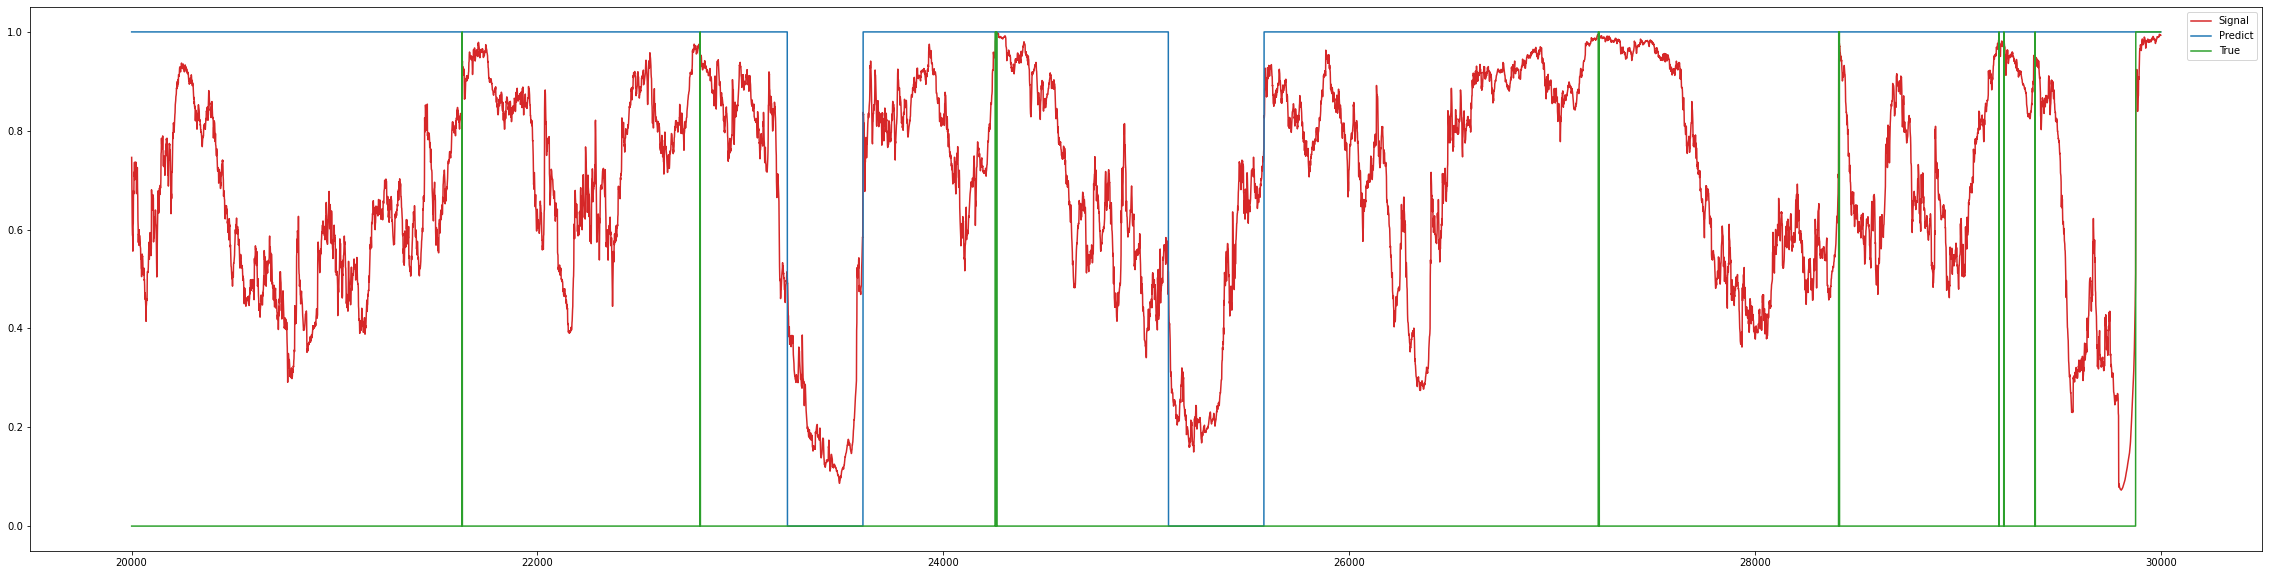

In [98]:
final_graph(20000, 30000, lr_origin, lr_sm_pred, true_test)

### Neural Networks

In [99]:
nn_sm_pred, nn_origin= neural_network(new_train_tuple, test_x, mode='train')

100%|██████████| 434646/434646 [02:13<00:00, 3261.97it/s]


In [100]:
ttf_nn = total_turn_taking(nn_sm_pred, true_test)
ttf_nn

,turn_taking
train,132
true_test,133


In [101]:
result(true_test, nn_sm_pred)

,result
AUC,0.887727
Accuracy,0.887237
Sensitivity,0.908882
Specificity,0.866573


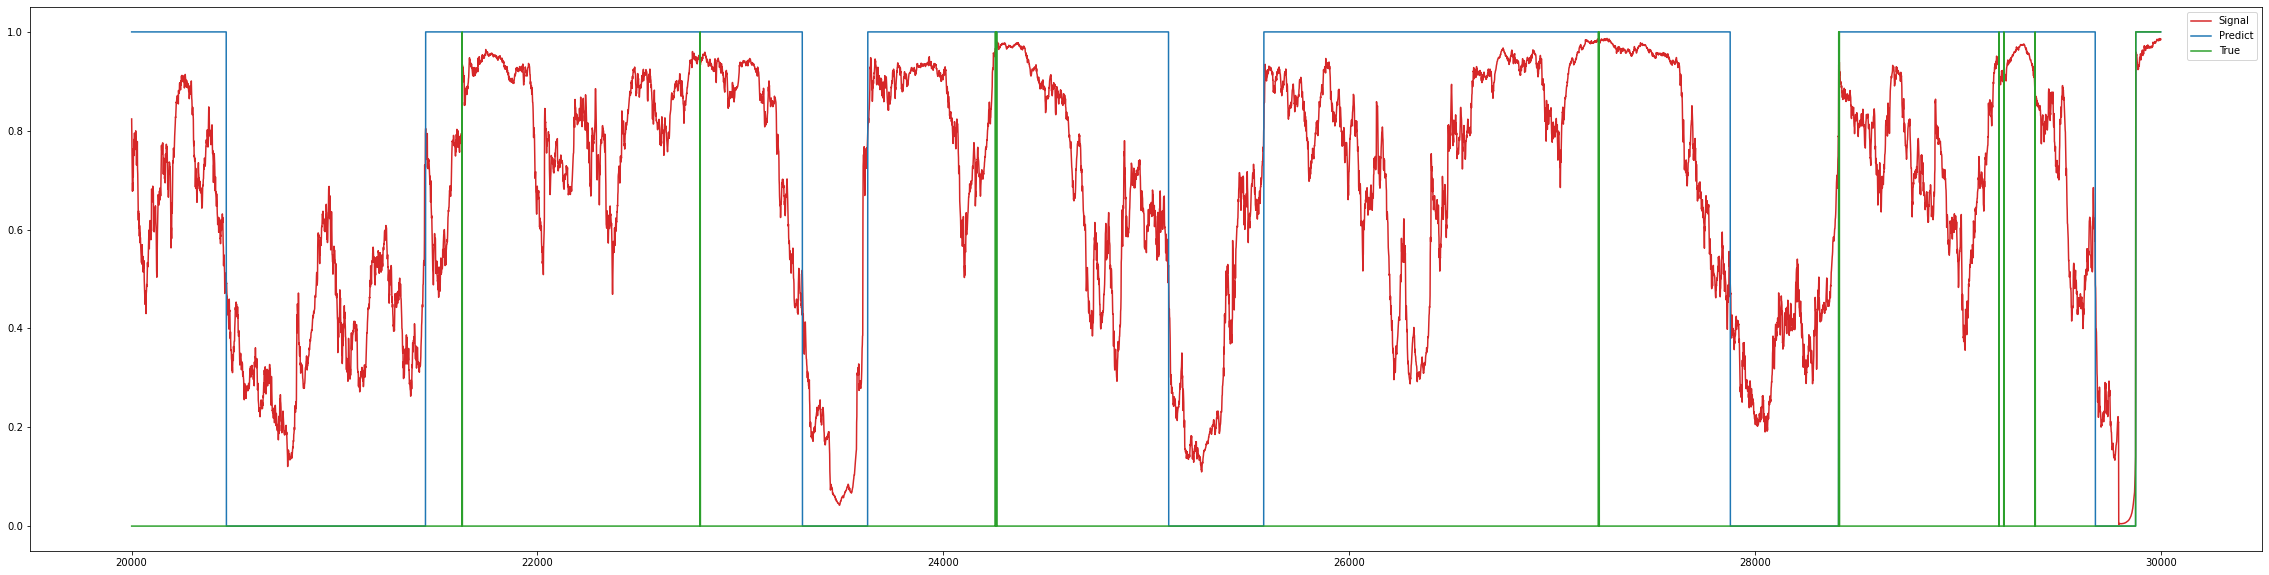

In [102]:
final_graph(20000, 30000, nn_origin, nn_sm_pred, true_test)

### Gradient Boosting

In [104]:
grb_sm_pred, grb_origin= gradient_boosting(new_train_tuple, test_x, mode='train')

100%|██████████| 434646/434646 [02:13<00:00, 3256.86it/s]


In [105]:
ttf_grb = total_turn_taking(grb_sm_pred, true_test)
ttf_grb

,turn_taking
train,133
true_test,133


In [106]:
result(true_test, grb_sm_pred)

,result
AUC,0.896268
Accuracy,0.895835
Sensitivity,0.914940
Specificity,0.877595


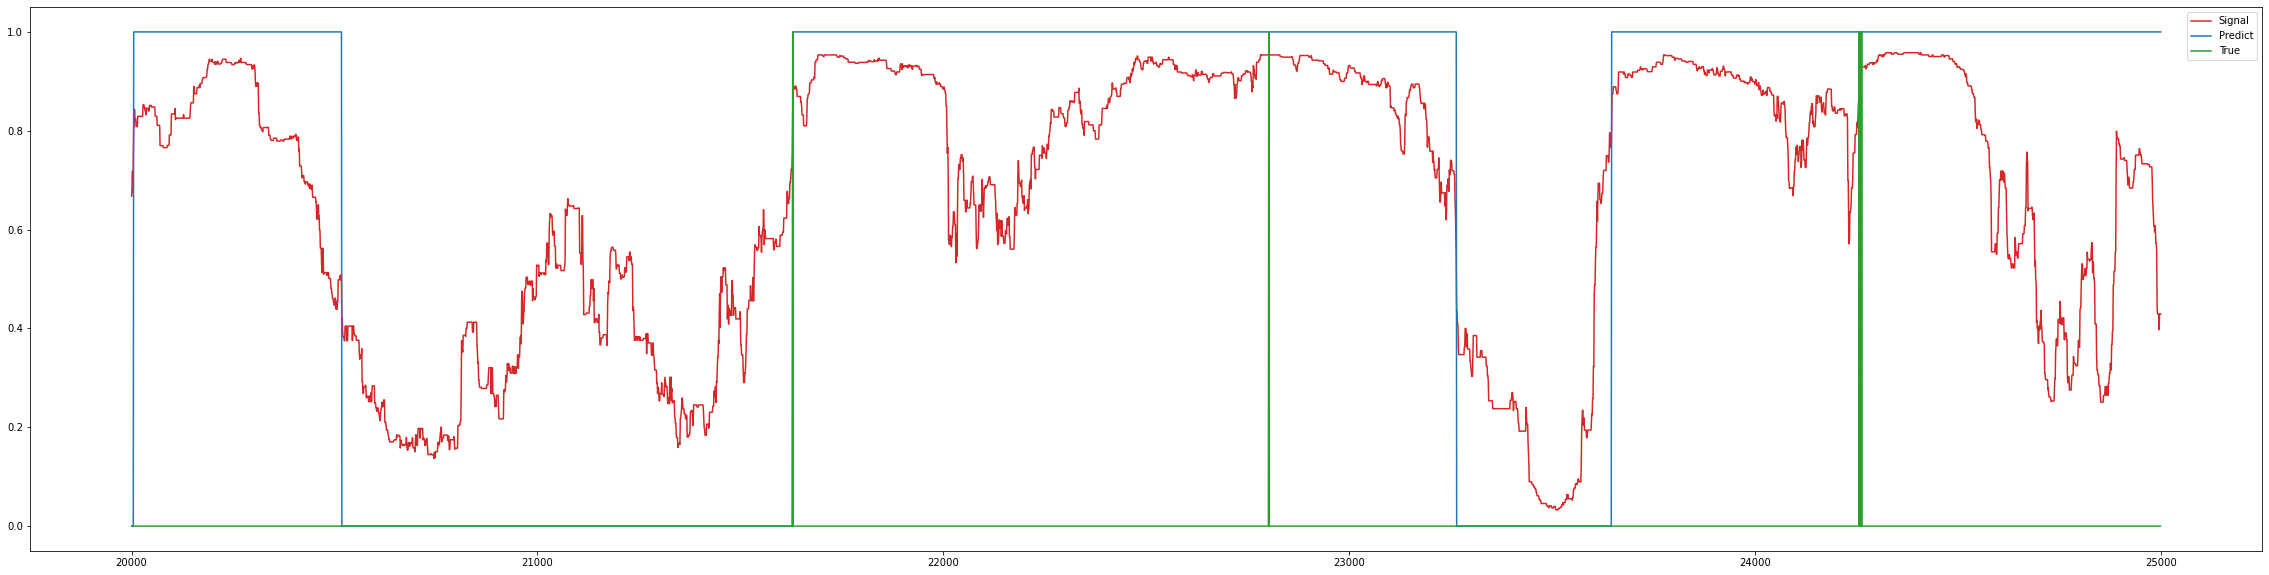

In [107]:
final_graph(20000, 25000, grb_origin, grb_sm_pred, true_test)

### LightGBM

In [108]:
lgb_sm_pred, lgb_origin = lightGBM(new_train_tuple, test_x, mode='train')

100%|██████████| 434646/434646 [02:15<00:00, 3205.95it/s]


In [109]:
ttf_voting = total_turn_taking(lgb_sm_pred, true_test)
ttf_voting

,turn_taking
train,141
true_test,133


In [110]:
result(true_test, lgb_sm_pred)

,result
AUC,0.894382
Accuracy,0.893444
Sensitivity,0.934833
Specificity,0.853931


### Voting classifier

In [111]:
voting_sm_pred, voting_origin = voting_classifier(new_train_tuple, test_x, mode='train')

100%|██████████| 434646/434646 [02:13<00:00, 3248.08it/s]


In [112]:
ttf_voting = total_turn_taking(voting_sm_pred, true_test)
ttf_voting

,turn_taking
train,128
true_test,133


In [113]:
result(true_test, voting_sm_pred)

,result
AUC,0.898009
Accuracy,0.897751
Sensitivity,0.909141
Specificity,0.886878


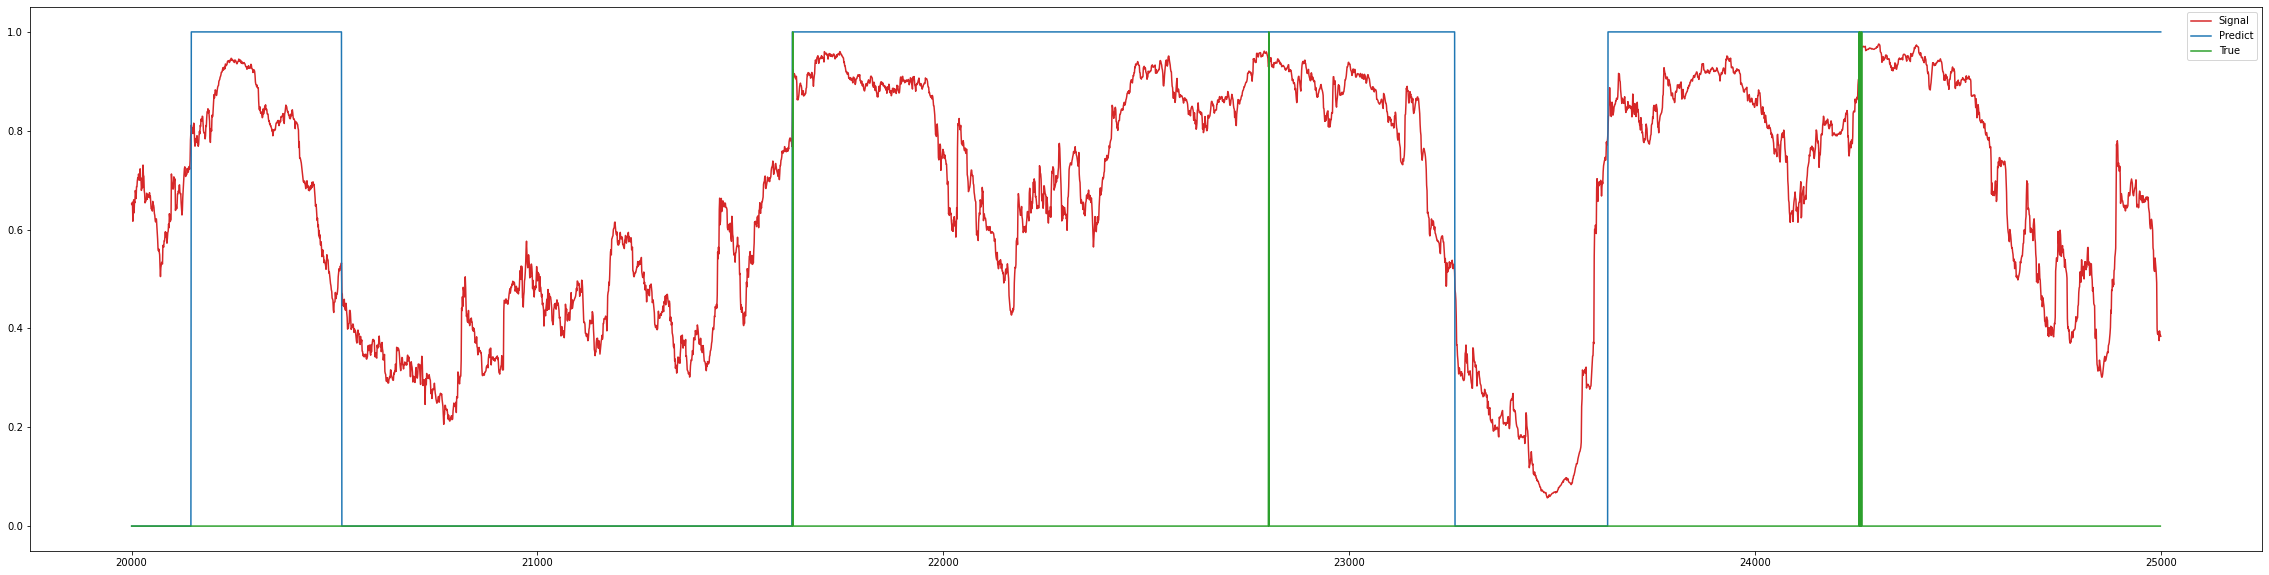

In [114]:
final_graph(20000, 25000, voting_origin, voting_sm_pred, true_test)

### stacking

In [115]:
stacking_sm_pred, stacking_origin = stacking_classifier(new_train_tuple, test_x, mode='train')

100%|██████████| 434646/434646 [02:23<00:00, 3034.89it/s]


In [116]:
ttf_stacking = total_turn_taking(stacking_sm_pred, true_test)
ttf_stacking

,turn_taking
train,132
true_test,133


In [117]:
result(true_test, stacking_sm_pred)

,result
AUC,0.898716
Accuracy,0.898087
Sensitivity,0.925821
Specificity,0.871610


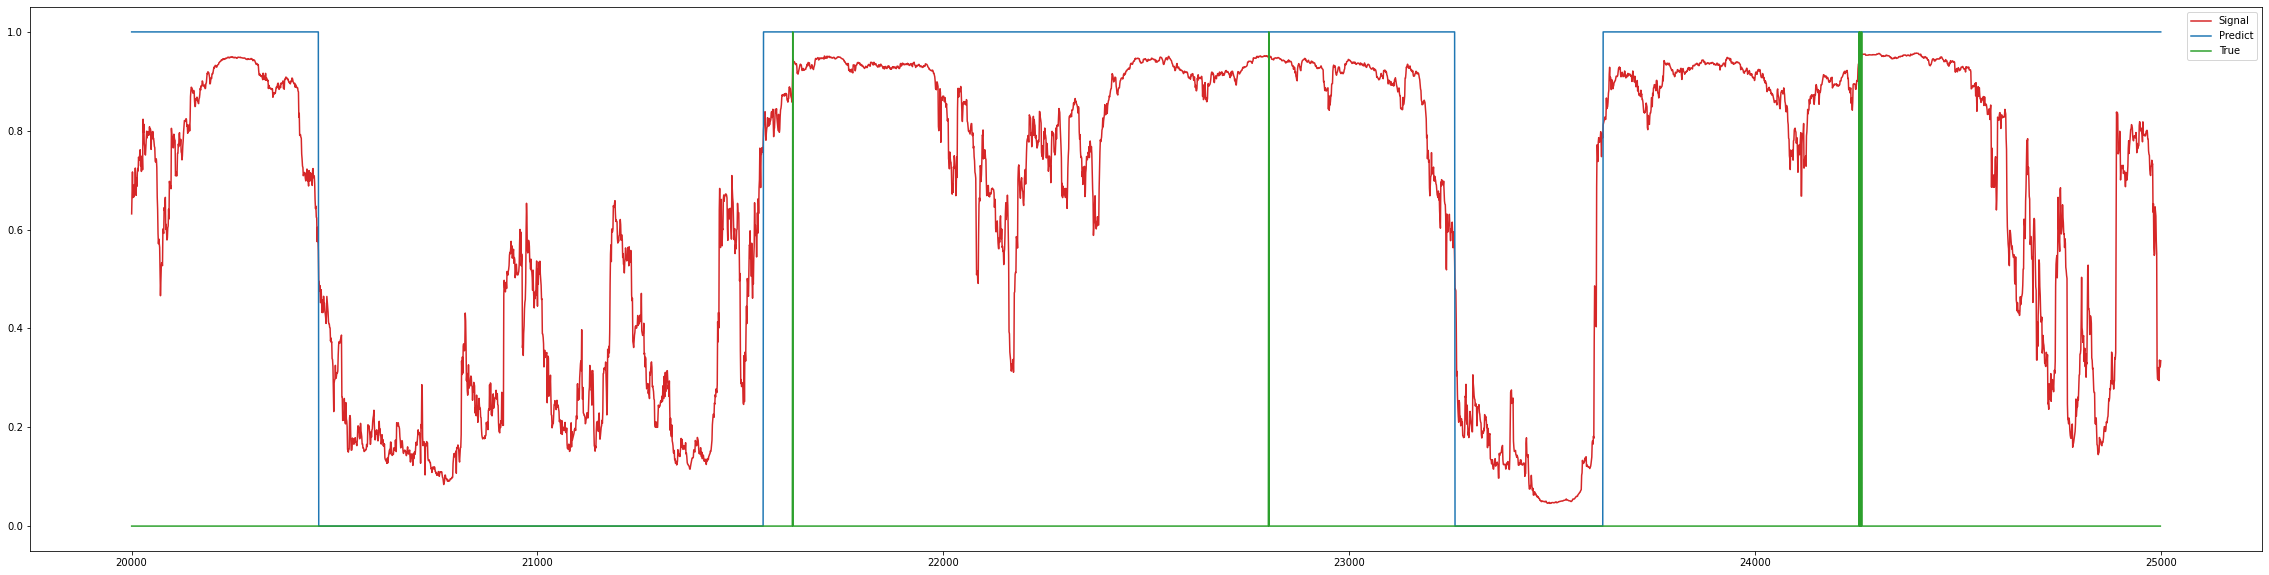

In [118]:
final_graph(20000, 25000, stacking_origin, stacking_sm_pred, true_test)

## 새로운 테스트셋

In [119]:
## 새로운 테스트셋 불러옴
new_test = pd.read_csv("./new_data/edit_test.csv")

In [120]:
## 새로운 테스트셋 필요없는 변수 정리 및 이름변경
# new_test = new_test[['t1_AMP', 't2_AMP', 't3_AMP', 't1_VAD', 't2_VAD', 't3_VAD']]
new_test.columns = ['x1', 'x2', 'x3', 'y1', 'y2', 'y3']
new_test

,x1,x2,x3,y1,y2,y3
0,2026,2107,2034,0,0,0.0
1,2047,2051,2042,0,0,0.0
2,2037,2013,2044,0,0,0.0
3,2035,2039,2041,0,0,0.0
4,2012,2019,2043,0,0,0.0
...,...,...,...,...,...,...
22380,2027,2040,2036,0,0,0.0
22381,2040,2042,2035,0,0,0.0
22382,2081,2053,2046,0,0,0.0
22383,2046,2042,2049,0,0,0.0


In [121]:
#normalization
norm_new = normalization(new_test)
#절대값 취하기
abs_new = absolute(norm_new)
# 각 시나리오 file 별로 x1, x2, x3와 y1,y2,y3를 행단위로 이어준다. 
concat_new = infile_concat(abs_new)


In [122]:
concat_new

,person,signal,talking
0,1.0,0.208610,0.0
1,1.0,0.000151,0.0
2,1.0,0.099259,0.0
3,1.0,0.119141,0.0
4,1.0,0.347784,0.0
...,...,...,...
67150,3.0,0.300160,0.0
67151,3.0,0.324791,0.0
67152,3.0,0.053844,0.0
67153,3.0,0.020051,0.0


In [123]:
feat_new = feature_generation(concat_new)
feat_new

,person,signal,ga10,ga50,ga100,ga200,ga300,sa10,sa50,sa100,...,ma50,ma100,ma200,ma300,sd10,sd50,sd100,sd200,sd300,talking
0,1.0,0.208610,0.121107,0.101677,0.092682,0.140234,0.310320,0.167943,0.099439,-0.080665,...,0.208610,0.208610,0.208610,0.208610,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,1.0,0.000151,0.122707,0.101476,0.092667,0.140380,0.310475,0.154233,0.098994,-0.074337,...,0.104380,0.104380,0.104380,0.104380,0.147403,0.147403,0.147403,0.147403,0.147403,0.0
2,1.0,0.099259,0.132612,0.101081,0.092638,0.140699,0.310777,0.140524,0.098550,-0.068009,...,0.102673,0.102673,0.102673,0.102673,0.104272,0.104272,0.104272,0.104272,0.104272,0.0
3,1.0,0.119141,0.148086,0.100507,0.092592,0.141185,0.311233,0.126815,0.098105,-0.061681,...,0.106790,0.106790,0.106790,0.106790,0.085535,0.085535,0.085535,0.085535,0.085535,0.0
4,1.0,0.347784,0.153152,0.099773,0.092528,0.141830,0.311827,0.113106,0.097661,-0.055353,...,0.154989,0.154989,0.154989,0.154989,0.130778,0.130778,0.130778,0.130778,0.130778,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67150,3.0,0.300160,0.183760,0.156555,0.149668,0.148661,0.155732,0.170713,0.154107,0.132500,...,0.143046,0.160317,0.178991,0.183264,0.094660,0.101351,0.121599,0.145850,0.156977,0.0
67151,3.0,0.324791,0.181867,0.157012,0.149764,0.148637,0.155706,0.171660,0.154533,0.131946,...,0.146987,0.163026,0.178791,0.183757,0.104604,0.104525,0.122219,0.145620,0.157189,0.0
67152,3.0,0.053844,0.172718,0.157367,0.149835,0.148618,0.155685,0.172608,0.154959,0.131393,...,0.147480,0.157854,0.178713,0.183675,0.110369,0.104015,0.115537,0.145683,0.157251,0.0
67153,3.0,0.020051,0.168418,0.157609,0.149885,0.148607,0.155672,0.173556,0.155385,0.130840,...,0.142061,0.156531,0.178668,0.183182,0.116681,0.103442,0.116355,0.145731,0.157532,0.0


In [124]:
new_test_x = feat_new.iloc[:,1:-1]
new_test_y = feat_new.iloc[:, -1]

In [125]:
new_true = pd.DataFrame(new_test_y).reset_index(drop=True)
new_true.columns= ['new_smth']
true_new = new_true.copy()

### Logistic regression

In [126]:
new_lr_sm_pred, new_lr_origin = logistic_regression(new_train_tuple, new_test_x, mode='test')

100%|██████████| 67155/67155 [00:20<00:00, 3250.29it/s]


In [127]:
new_turn = total_turn_taking(new_lr_sm_pred,  true_new)

In [128]:
new_turn

,turn_taking
train,39
true_test,45


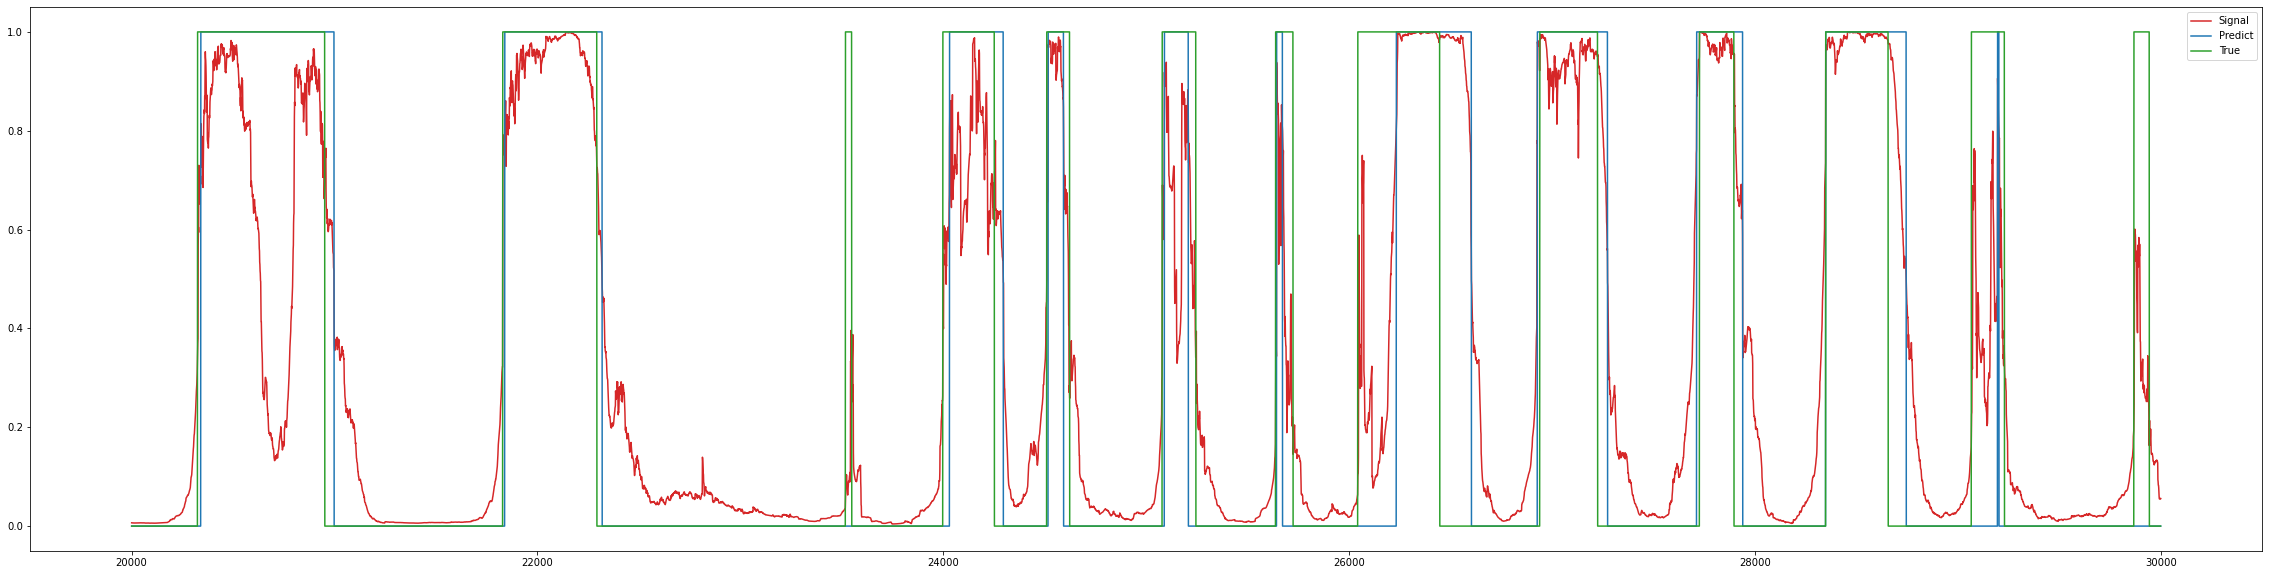

In [129]:
final_graph(20000, 30000, new_lr_origin, new_lr_sm_pred, new_true)

In [130]:
result(new_true, new_lr_sm_pred)

,result
AUC,0.892205
Accuracy,0.914020
Sensitivity,0.851003
Specificity,0.933406


### Neural Network

In [131]:
new_nn_sm_pred, new_nn_origin = neural_network(new_train_tuple, new_test_x, mode='test')

100%|██████████| 67155/67155 [00:21<00:00, 3162.29it/s]


In [132]:
new_turn_nn = total_turn_taking(new_nn_sm_pred, new_true)
new_turn_nn

,turn_taking
train,44
true_test,45


In [133]:
result(new_true, new_nn_sm_pred)

,result
AUC,0.914829
Accuracy,0.947048
Sensitivity,0.853978
Specificity,0.975680


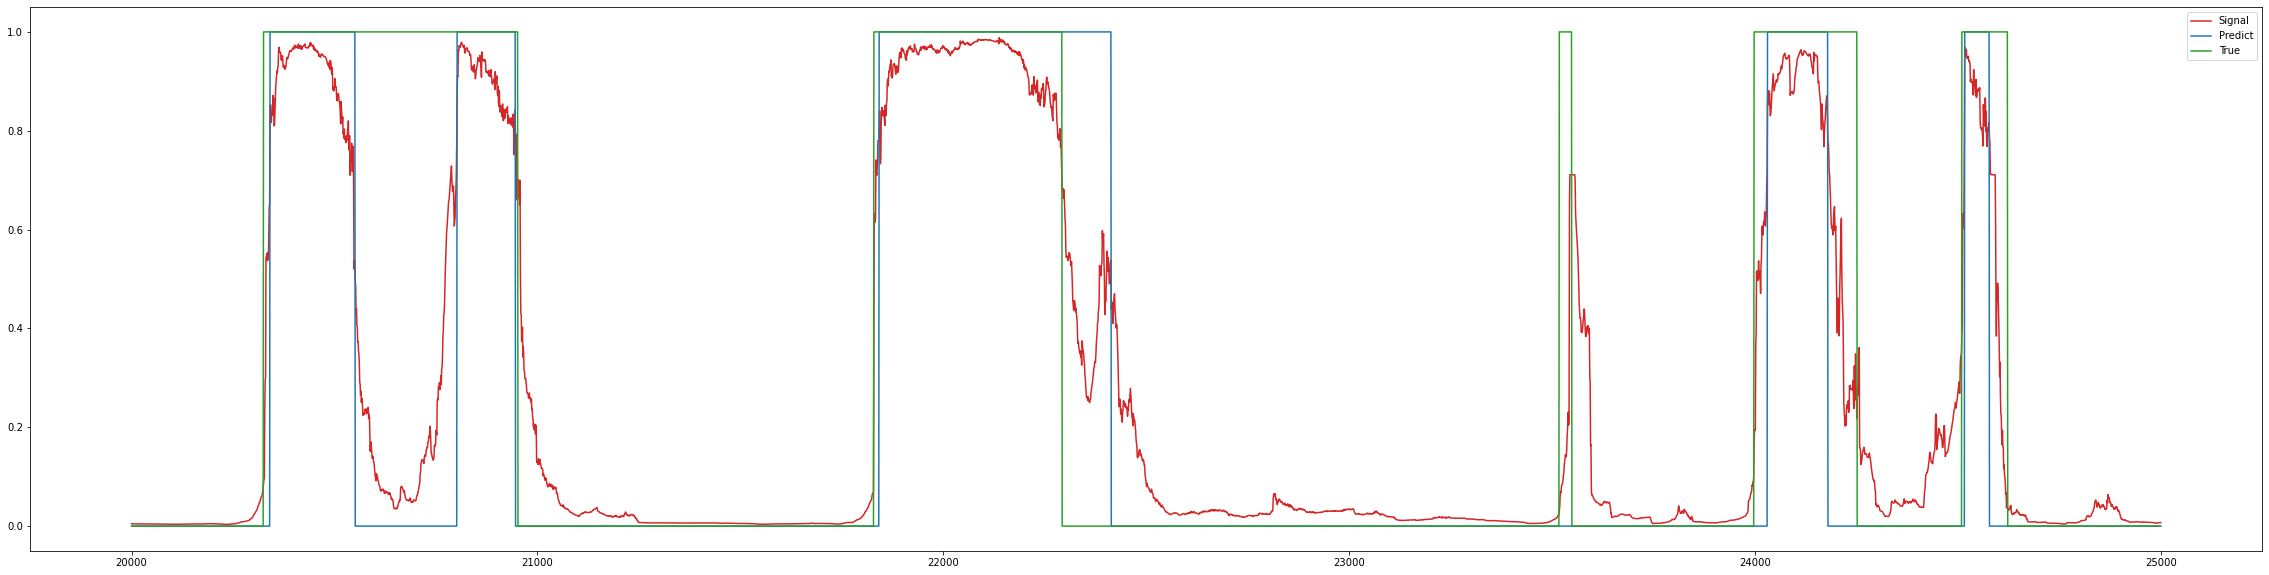

In [134]:
final_graph(20000, 25000, new_nn_origin, new_nn_sm_pred, new_true)

### Gradient Boosting

In [135]:
new_grb_sm_pred, new_grb_origin = gradient_boosting(new_train_tuple, new_test_x, mode="test")

100%|██████████| 67155/67155 [00:20<00:00, 3327.19it/s]


In [136]:
new_turn_grb = total_turn_taking(new_grb_sm_pred, new_true)
new_turn_grb

,turn_taking
train,38
true_test,45


In [137]:
result(new_true, new_grb_sm_pred)

,result
AUC,0.921430
Accuracy,0.943102
Sensitivity,0.880499
Specificity,0.962361


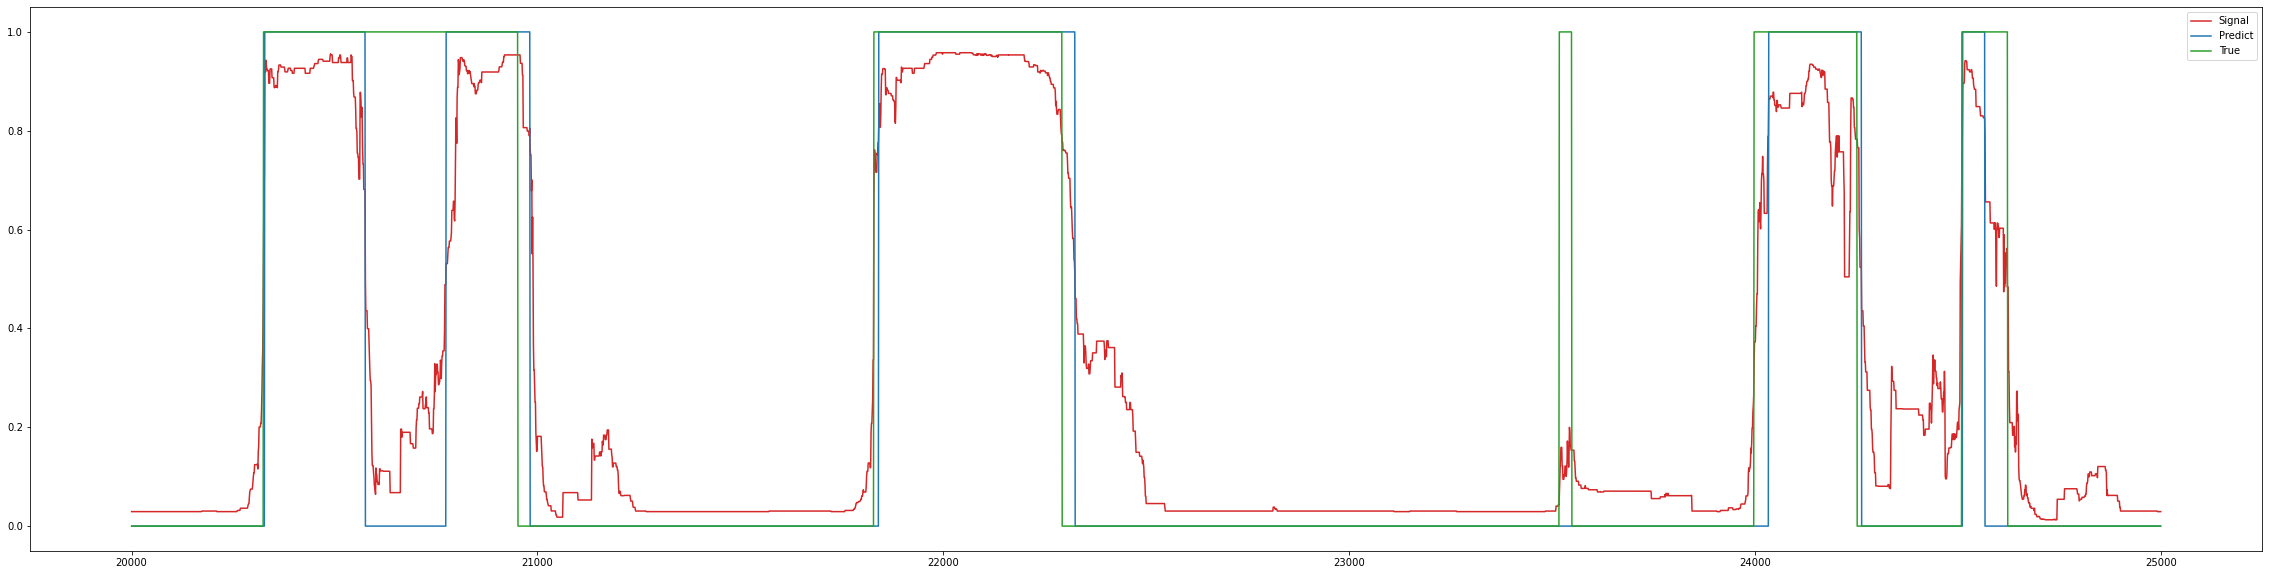

In [138]:
final_graph(20000, 25000, new_grb_origin, new_grb_sm_pred, new_true)

### LightGBM

In [139]:
new_lgb_sm_pred, new_lgb_origin = lightGBM(new_train_tuple, new_test_x, mode='test')

100%|██████████| 67155/67155 [00:21<00:00, 3183.58it/s]


In [140]:
new_turn_lgb = total_turn_taking(new_lgb_sm_pred, new_true)
new_turn_lgb

,turn_taking
train,41
true_test,45


In [141]:
result(new_true, new_lgb_sm_pred)

,result
AUC,0.930940
Accuracy,0.942566
Sensitivity,0.908982
Specificity,0.952897


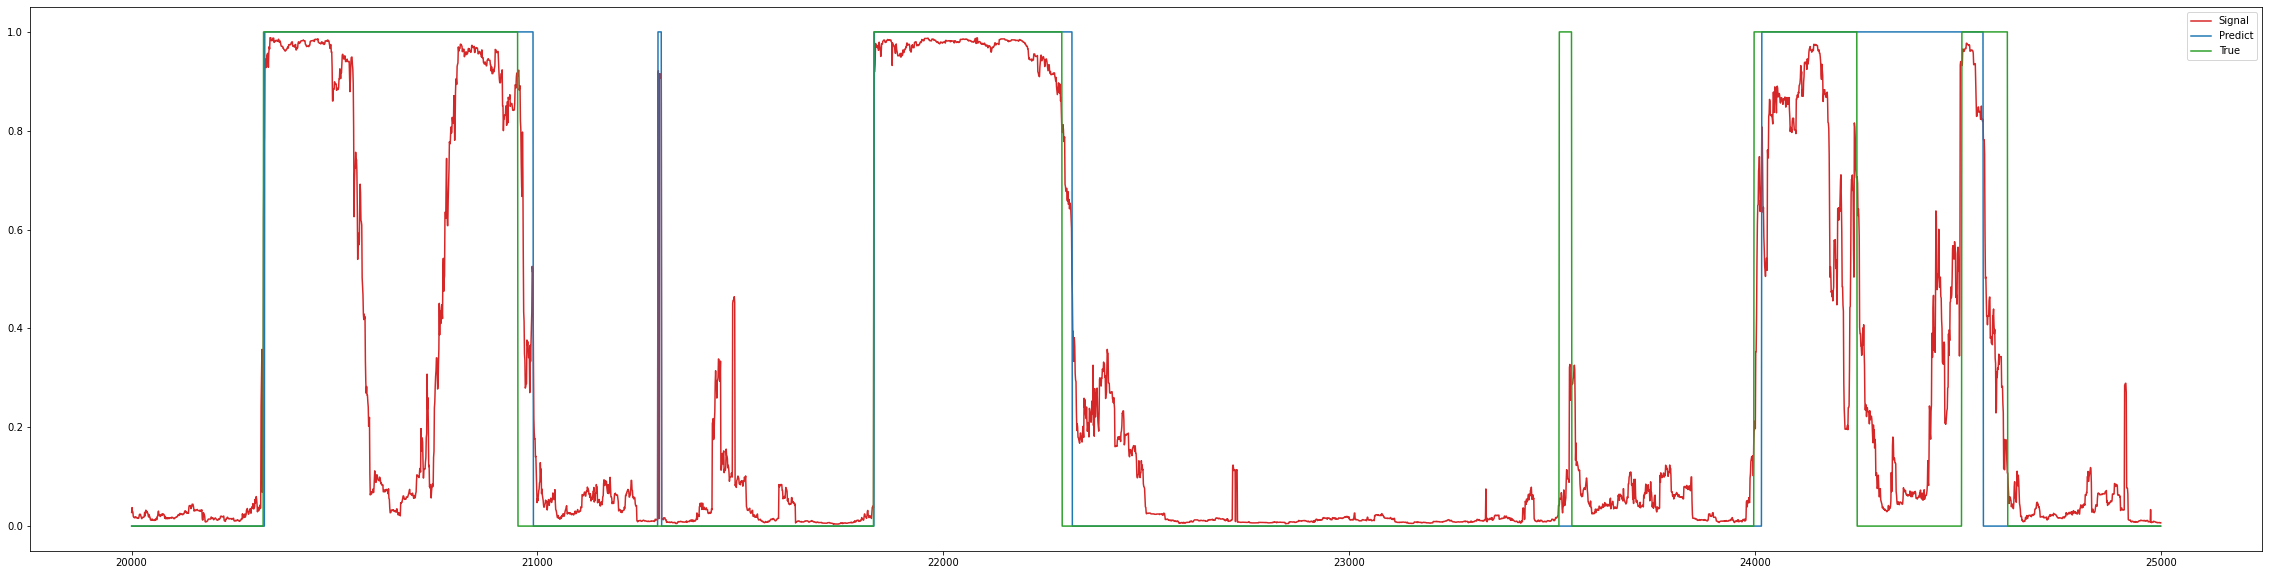

In [142]:
final_graph(20000, 25000, new_lgb_origin, new_lgb_sm_pred, new_true)

### Voting Classifier(lr, lightGBM, nn, grb)

In [143]:
new_voting_sm_pred, new_voting_origin = voting_classifier(new_train_tuple, new_test_x, mode='test')

100%|██████████| 67155/67155 [00:20<00:00, 3273.56it/s]


In [144]:
new_turn_voting = total_turn_taking(new_voting_sm_pred, new_true)
new_turn_voting

,turn_taking
train,38
true_test,45


In [145]:
result(new_true, new_voting_sm_pred)

,result
AUC,0.904696
Accuracy,0.931919
Sensitivity,0.853282
Specificity,0.956110


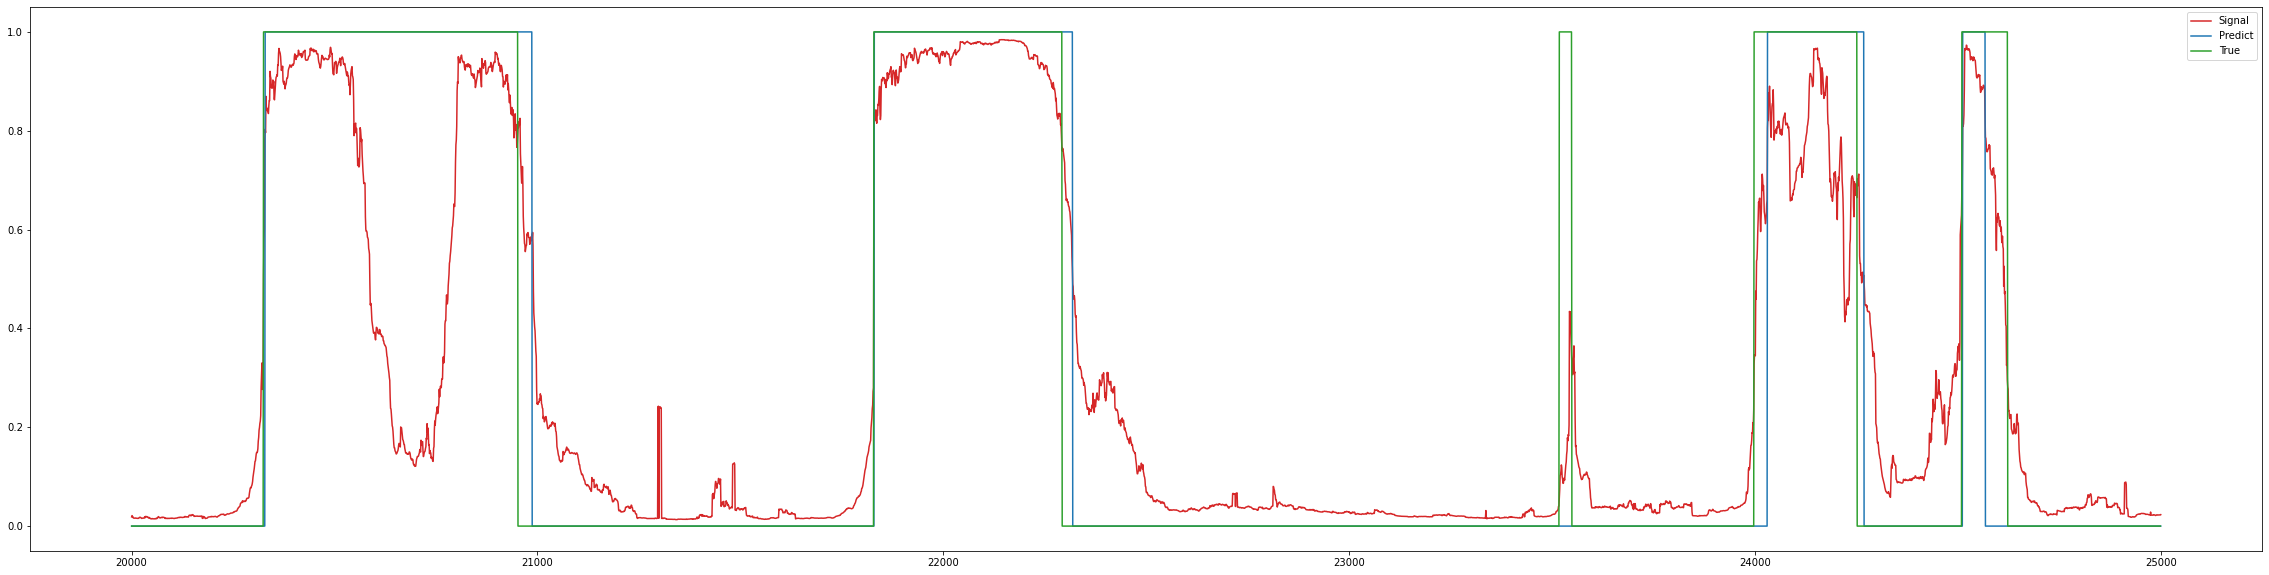

In [146]:
final_graph(20000, 25000, new_voting_origin, new_voting_sm_pred, new_true)

### stacking(lr, lightGBM, nn, grb)

In [147]:
new_stacking_sm_pred, new_stacking_origin = stacking_classifier(new_train_tuple, new_test_x, mode='test')

100%|██████████| 67155/67155 [00:20<00:00, 3286.89it/s]


In [148]:
new_turn_stacking = total_turn_taking(new_stacking_sm_pred, new_true)
new_turn_stacking

,turn_taking
train,39
true_test,45


In [149]:
result(new_true, new_stacking_sm_pred)

,result
AUC,0.935194
Accuracy,0.951619
Sensitivity,0.904171
Specificity,0.966216


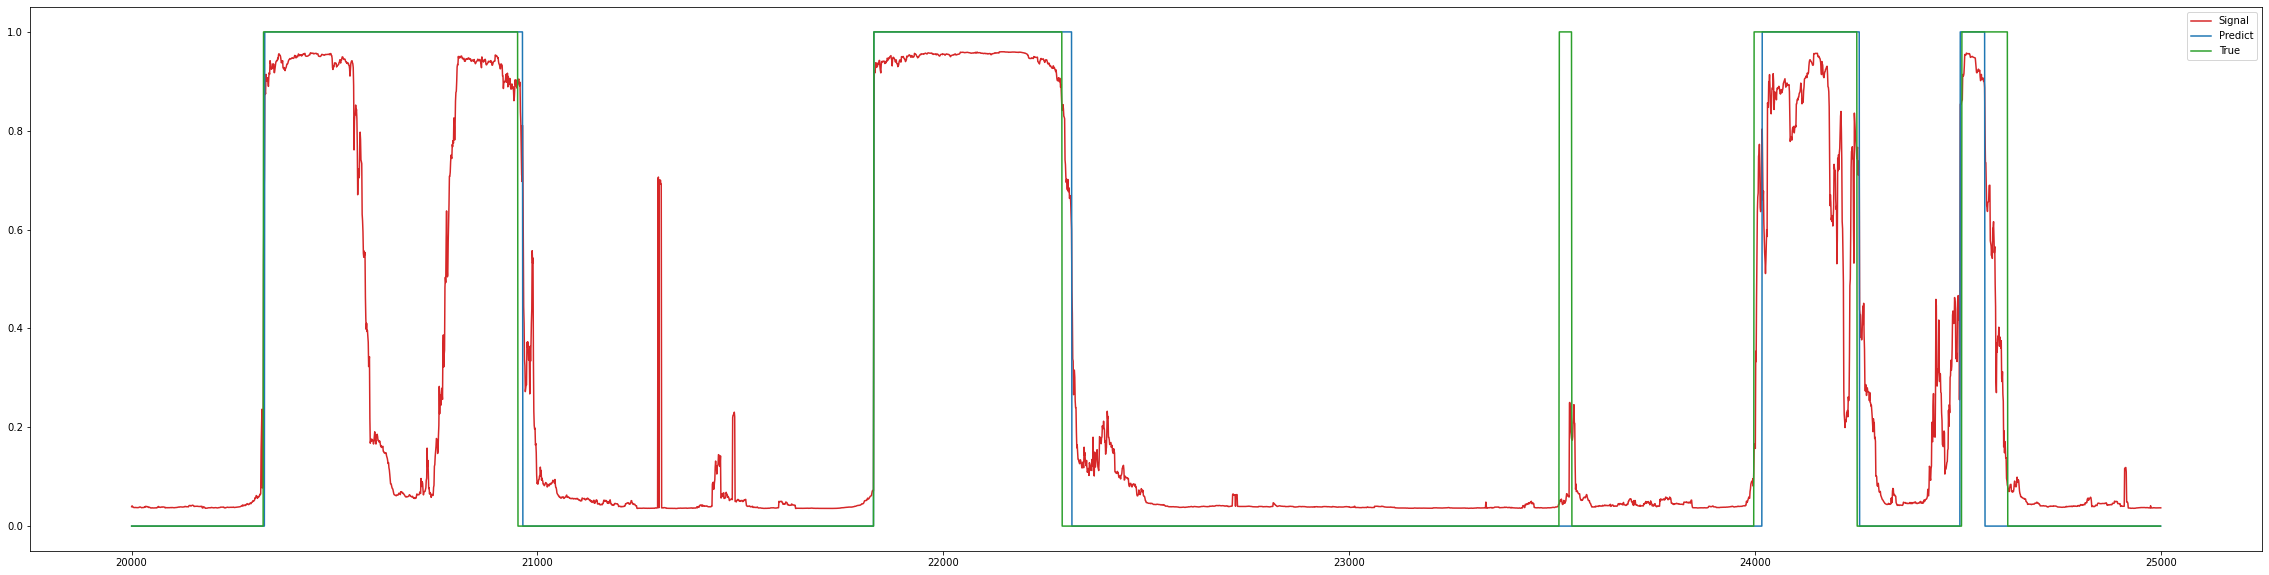

In [150]:
final_graph(20000, 25000, new_stacking_origin, new_stacking_sm_pred, new_true)